# WISESize Master Notebook

### This notebook contains the figures and plots I worked on for the WISESize Project. It is divided up into sections that each tackle a different problem.

In [1]:
# Libraries
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings

# Path to the catalog
catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/'

#A100-NSA Catalog
myTab=Table.read(catalog_path+'a100-nsa-for-adap.fits')

## Generating Figures from the Proposal Paper

### Here there cuts being applied to the catalog (myTab). The proposal suggests cuts of SNR > 20, size > 6.5", and redshifts between 0.002 and 0.025.

In [2]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag = W3flag | NUVflag

In [3]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 5.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag = (rad_eff1>radmin) | (rad_eff2>radmin)

In [4]:
# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

In [5]:
# Apply cuts
NSFcut = SNRflag & sizeflag & zflag
cuttab=myTab[NSFcut] # Catalog with all cuts from the proposal applied to it

## RA vs. Dec Plot

13756


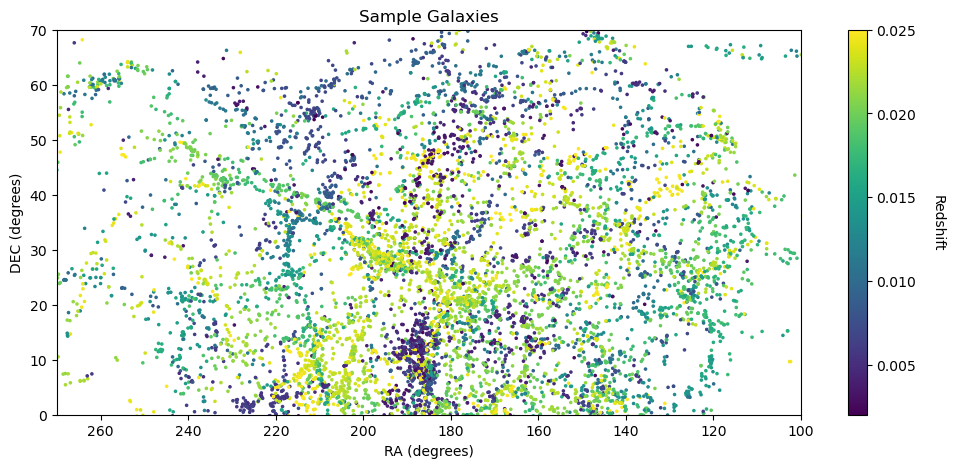

In [49]:
#Define positional and color data
ra = cuttab['RA'] # Right ascension in degrees
dec = cuttab['DEC'] # Declination in degrees
ccode = cuttab['ZDIST'] # Redshift

#Print number of points
print(len(ra))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='viridis',s=2.5) # Plots ra and dec color coded by redshift
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Redshift',rotation=270,labelpad=20)
plt.clim(0.002,0.025)

#### This is my recreation of figure 1d from the proposal. It shows the sample that is being proposed.

## Resolved Sample Plot

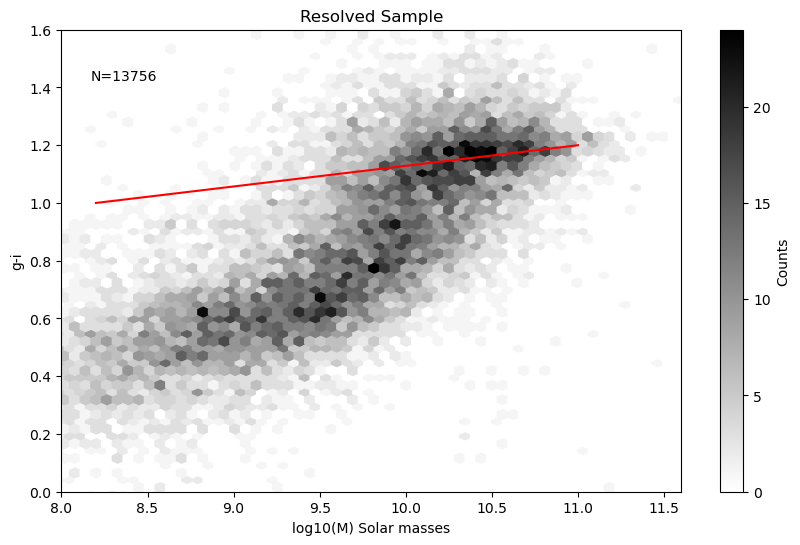

In [52]:
x1 = cuttab['MASS']
y1 = cuttab['ABSMAG'][:,3] - cuttab['ABSMAG'][:,5] #g-i magnitudes, FNUGRIZ- G[:,3] & I[:,5]

#Put x and y into numpy arrays
npx = np.array(np.log10(x1)) 
npy = np.array(y1)

#Figure size
fig,ax = plt.subplots(figsize=(10, 6))

#Hexbin parameters
hb = ax.hexbin(npx,npy,gridsize=[150,850],bins=25,cmap='gray_r')

#Plot hexbin mass vs color diagram
plt.title('Resolved Sample')
ax.set(xlim=(8,11.6),ylim=(0,1.6)) 
fig.colorbar(hb, label='Counts') 
plt.xlabel('log10(M) Solar masses') 
plt.ylabel('g-i')

#Plot Red Sequence line
xx=np.array([8.2 ,11])
yy=np.array([ 1,  1.2])
plt.plot(xx,yy,color='r')
plt.text(0.1,0.9,'N=13756',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### This is figure 2a from the proposal. The red line represents the red sequence. The majority of our sample is made up of blue, star forming galaxies but there is a cluster of AGN and inclined galaxies on the red sequence.

## Sample Histograms

In [30]:
#cuttab.info

Text(0.5, 0, 'r-band Half-Light Radius (arcsec)')

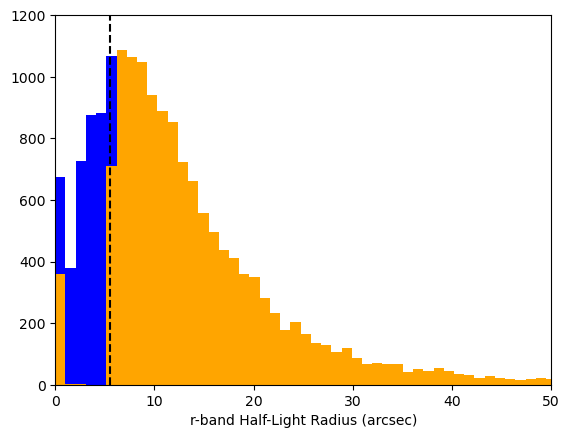

In [74]:
#New cut dataset
cut = SNRflag & zflag
tab=myTab[cut]


#Half light radii
sersicR501 = tab['SERSIC_TH50']
sersicR502 = cuttab['SERSIC_TH50']

#Arrays of half light radii
p501 = np.array(sersicR501)
p502 = np.array(sersicR502)

#Plot histogram of half light radii
plt.hist(p501,bins=155,color='blue')
plt.hist(p502,bins=155,color='orange')
plt.axvline(x=5.5, color='black', linestyle='dashed')
plt.xlim(0,50)
plt.ylim(0,1200)
plt.xlabel('r-band Half-Light Radius (arcsec)')

Text(0.5, 0, '90% Petrosian Radius (arcsec)')

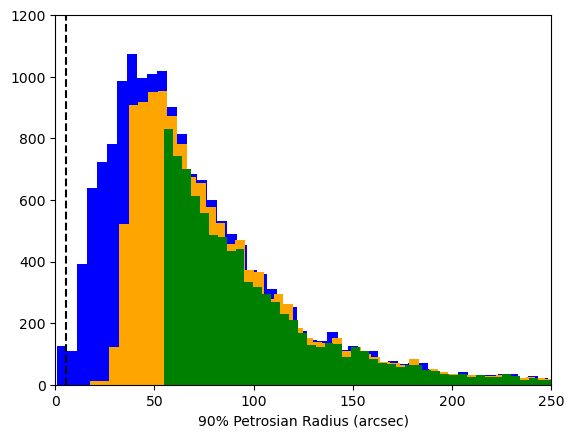

In [67]:
# New cut dataset
zeroflag = (myTab['PETROTH90']>0)
zeroflag2 = (cuttab['PETROTH90']>5.5)
zeroflag3 = (myTab['PETROTH90']>17.4)

cut = SNRflag & zflag & zeroflag
tab=myTab[cut]

cut2 = zeroflag2
tab2 = cuttab[cut2]

radmin2 = 17.400
rad_eff12 = myTab['SERSIC_TH50']
rad_eff22 = myTab['petroR50_r']
sizeflag2 = (rad_eff12>radmin2) | (rad_eff22>radmin2)

cut3 = SNRflag & zflag & zeroflag3
tab3 = myTab[cut3]

# 90% petrosian radii
petroR901 = tab['PETROTH90']
petroR902 = tab2['PETROTH90']
petroR903 = tab3['PETROTH90']

# Arrays of petrosian radii
p901 = np.array(petroR901)
p902 = np.array(petroR902)
p903 = np.array(petroR903)

# Plot histogram of half light radii
plt.hist(3.16*p901,bins=95,color='blue')
plt.hist(3.16*p902,bins=95,color='orange')
plt.hist(3.16*p903,bins=95,color='green')
plt.axvline(x=5.5, color='black', linestyle='dashed')
plt.xlim(0,250)
plt.ylim(0,1200)
plt.xlabel('90% Petrosian Radius (arcsec)')

## Comparing Cut Samples

#### I experimented with using different values for the SNR and size cuts and created some plots comparing them.

In [76]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag20 = W3flag | NUVflag

In [77]:
# Size cut: r-band effective radii greater than two pixels (> 5.500" ) in the unWISE images
radmin = 5.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag55 = (rad_eff1>radmin) | (rad_eff2>radmin)

In [78]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 10
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag10 = W3flag | NUVflag

In [79]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag65 = (rad_eff1>radmin) | (rad_eff2>radmin)

In [80]:
# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

In [ ]:
# Apply cuts
NSFcut1 = SNRflag20 & sizeflag55 & zflag
cuttab1 = myTab[NSFcut1]

NSFcut2 = SNRflag10 & sizeflag55 & zflag
cuttab2 = myTab[NSFcut2]

NSFcut3 = SNRflag10 & sizeflag65 & zflag
cuttab3 = myTab[NSFcut3]

NSFcut4 = SNRflag20 & sizeflag65 & zflag
cuttab4 = myTab[NSFcut4]

### Redshift Histogram

Text(0.5, 0, 'Redshift')

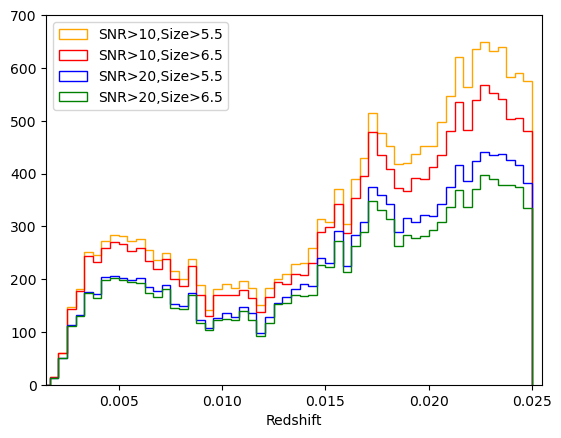

In [82]:
a = cuttab1['ZDIST']#5.5 and 20
b = cuttab2['ZDIST']#5.5 and 10
c = cuttab3['ZDIST']#6.5 and 10
d = cuttab4['ZDIST']#6.5 and 20

plt.hist(b,bins=60,histtype='step',color='orange',fill=False,label='SNR>10,Size>5.5')
plt.hist(c,bins=60,histtype='step',color='red',fill=False,label='SNR>10,Size>6.5')
plt.hist(a,bins=60,histtype='step',color='blue',fill=False,label='SNR>20,Size>5.5')
plt.hist(d,bins=60,histtype='step',color='green',fill=False,label='SNR>20,Size>6.5')
plt.legend()
plt.xlim(0.0015,0.0255)
plt.ylim(0,700)
plt.xlabel('Redshift')

#### This histogram shows the how the number of galaxies is distributed for along redshifts. Its apparent that the green and blur samples are very similar, especially at low redshifts. The red and orange samples are close as well. This suggests changing the size cut does not change the sample size much. We decided to stick with the originally proposed cut of SNR>20 and size>6.5".